# Курсовой проект.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(8)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191


In [7]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(8)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4992,8834,81,1.0,36.848987,23.489930,10.0,5,12.0,1970,0.006076,B,B,30,5285,0,645.0,6,6,B
4993,14676,6,1.0,48.435108,NaN,1.0,18,25.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4994,13060,25,2.0,51.144906,48.979540,1.0,18,25.0,2015,0.069753,B,B,53,13670,4,NaN,1,11,B
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


### Приведение типов

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## Подготовка датасета:
### - Исправления выбросов
### - Заполнения NaN
### - Идей для генерации новых фич

**Целевая переменная**

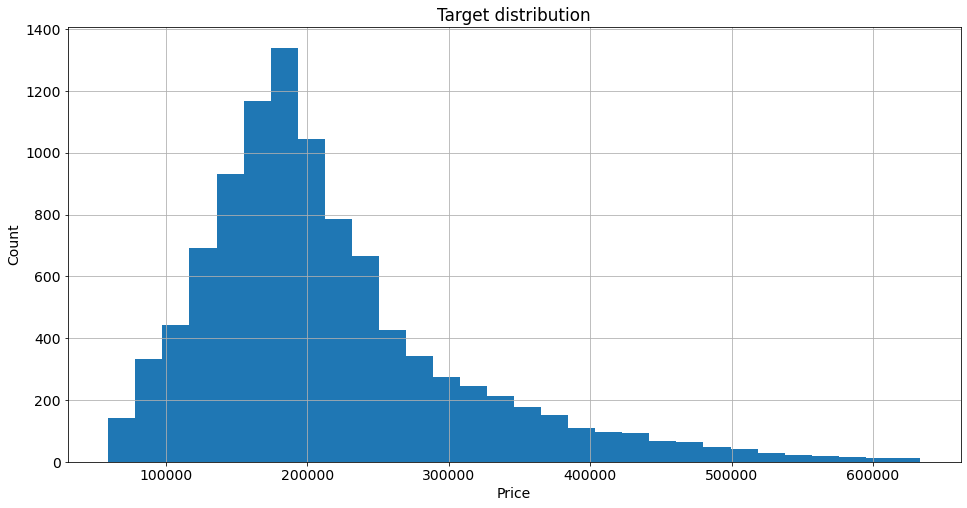

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Распределение целевой переменной близко к нормальному. 

**Количественные переменные**

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


NaN содержатся в двух признаках: LifeSquare и Healthcare_1

Выбросы имеются по минимальному и максимальному значению: Rooms, Square, LifeSquare, Floor

**Номинативные переменные**

In [14]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '_' * 50 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
__________________________________________________

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
__________________________________________________

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
__________________________________________________



###  Обработка выбросов 

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Rooms**

In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Если в квартире 0 комнат, то делаем 1 комнату.
Если больше 6 комнат, то делаем число комнат, равным медиане.

In [18]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [19]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square**

In [20]:
train_df['Square'].sort_values()

7470      1.136859
4496      1.988943
9869      2.377248
8572      2.596351
161       2.954309
           ...    
7644    212.932361
1906    275.645284
7010    409.425181
726     604.705972
9229    641.065193
Name: Square, Length: 10000, dtype: float64

In [21]:
train_df['Square'].quantile(.975), train_df['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

Квартиры с площадью больше 110 кв м с большой вероятностью окажутся выбросными. Заменим очень большие площади на медиану, а слишком маленькие на значение 28 (примерная минимальная площадь жилой квартиры).

In [22]:
train_df.loc[train_df['Square'] > 120, 'Square'] = train_df['Square'].median()
train_df.loc[train_df['Square'] < 28, 'Square'] = 28

In [23]:
train_df['Square'].value_counts()

52.513310    92
28.000000    62
52.327165     1
86.164240     1
68.088569     1
             ..
58.099871     1
79.855806     1
39.230485     1
42.080866     1
64.226361     1
Name: Square, Length: 9848, dtype: int64

**KitchenSquare** 

In [24]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [25]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Площадь кухни меньше 3 квадратных метров нереальна, поэтому приравниваем площадь к трем метрам квадратным во всех таких случаях. Выше квантиля 0,975 приравниваем площадь к медиане.

In [26]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [27]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [28]:
(train_df['KitchenSquare'] > train_df['Square']).sum()

0

После преобразований не осталось квартир, в которых значения площади кухни больше чем у всей квартиры.

**HouseFloor, Floor**

In [29]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [30]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [31]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [32]:
train_df['HouseFloor_issue'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_issue'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_issue'] = 1

In [33]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [34]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [35]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']

In [36]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

После преобразований не осталось квартир, которые находились бы на несуществующем в доме этаже.

**HouseYear**

In [37]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [38]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

Text(0.5, 1.0, 'Distribution of variable House Year')

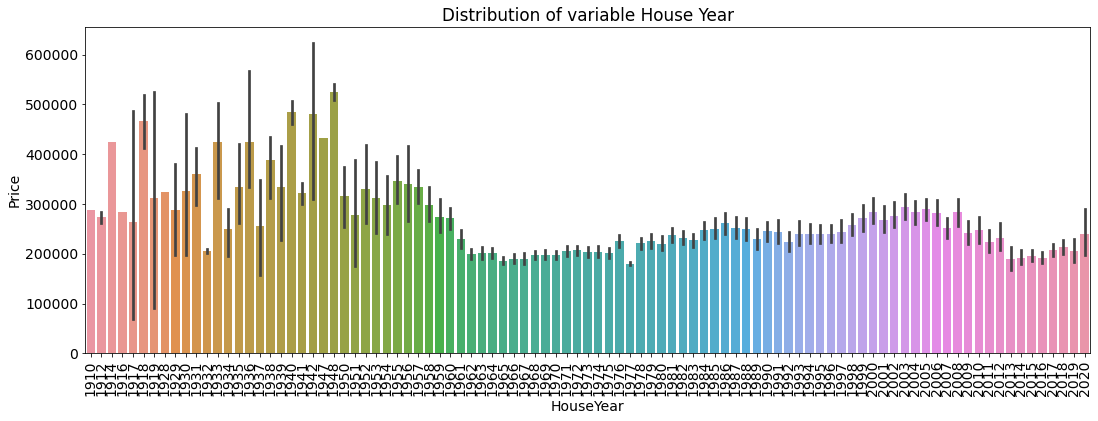

In [39]:
plt.figure(figsize=(18, 6))
sns.barplot(train_df['HouseYear'], train_df['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

### Обработка пропусков

In [40]:
train_df.isna().sum()

Id                     0
DistrictId             0
Rooms                  0
Square                 0
LifeSquare          2113
KitchenSquare          0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Ecology_2              0
Ecology_3              0
Social_1               0
Social_2               0
Social_3               0
Healthcare_1        4798
Helthcare_2            0
Shops_1                0
Shops_2                0
Price                  0
Rooms_outlier          0
HouseFloor_issue       0
dtype: int64

**LifeSquare**

In [41]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [42]:
(train_df['LifeSquare'] > train_df['Square']).sum()

515

После всех преобразований осталось 548 квартир, в которых жилая площадь больше площади квартиры. В этом случае тоже приравняем площадь выражению: площадь квартиры минус площадь кухни минус 3 (примерный запас на нежилое пространство)

In [43]:
condition = train_df['LifeSquare'] > train_df['Square']
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3
(train_df['LifeSquare'] > train_df['Square']).sum()

0

**Healthcare_1**

У данного показателя много пропущенных значений, однако есть предположение, что он может находиться в зависимости от показателя Helthcare_2

In [44]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_issue,LifeSquare_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,55.417928,38.711368,6.238200,7.918200,12.95910,1984.86600,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300
std,0.811438,17.056737,17.492944,2.794717,5.186386,6.44346,18.41187,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251
min,1.000000,28.000000,0.370619,3.000000,1.000000,1.00000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,1.000000,41.774881,25.038231,3.000000,4.000000,9.00000,1974.00000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000
50%,2.000000,52.513040,35.020639,6.000000,7.000000,13.00000,1977.00000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000
75%,2.000000,65.481313,47.856276,8.000000,11.000000,17.00000,2001.00000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000
max,5.000000,119.914990,117.446940,13.000000,42.000000,117.00000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [45]:
df_cat = train_df.groupby('Helthcare_2', as_index=False).median()[['Helthcare_2', 'Healthcare_1']]
df_cat = pd.DataFrame(df_cat)
df_cat

,Helthcare_2,Healthcare_1
0,0,540.0
1,1,620.0
2,2,750.0
3,3,1145.0
4,4,1894.0
5,5,1575.0
6,6,645.0


Если сгруппировать по Helthcare_2 и вычислить медиану Healthcare_1, то получим 7 групп с относительно разными величинами Helthcare_1. Можно попробовать заменить пропущенные значения данными величинами.

In [46]:
hc = train_df['Helthcare_2']
hc = pd.DataFrame(hc)
hc = hc.merge(df_cat, on=['Helthcare_2'], how="left")
hc

,Helthcare_2,Healthcare_1
0,0,540.0
1,1,620.0
2,3,1145.0
3,0,540.0
4,0,540.0
...,...,...
9995,1,620.0
9996,0,540.0
9997,1,620.0
9998,3,1145.0


In [47]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1
train_df = train_df.fillna(hc)

In [48]:
train_df.loc[train_df['Healthcare_1_nan']==1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,540.0,0,0,B,305018.871089,0,0,1,1
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,540.0,0,1,B,168106.007630,0,0,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,2,540.0,0,6,B,343995.102962,0,0,0,1
8,9951,1,1.0,46.887892,44.628132,3.0,12.0,20.0,1977,0.007122,...,0,540.0,0,1,B,160400.401732,0,0,0,1
11,16755,88,2.0,53.975144,34.153584,8.0,2.0,12.0,1978,0.127376,...,3,1145.0,3,9,B,253124.005332,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,78.486078,3.0,4.0,22.0,2016,0.007122,...,0,540.0,0,1,B,264213.558631,0,0,0,1
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,...,6,620.0,1,9,B,119367.455796,0,0,0,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,1,540.0,0,0,A,199715.148807,0,1,0,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,...,14,620.0,1,5,B,165953.912580,0,0,0,1


In [49]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,55.417928,38.711368,6.238200,7.918200,12.95910,1984.86600,0.118858,24.687000,5352.157400,8.039200,903.594400,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300,0.479800
std,0.811438,17.056737,17.492944,2.794717,5.186386,6.44346,18.41187,0.119025,17.532614,4006.799803,23.831875,794.736377,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251,0.499617
min,1.000000,28.000000,0.370619,3.000000,1.000000,1.00000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774881,25.038231,3.000000,4.000000,9.00000,1974.00000,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000
50%,2.000000,52.513040,35.020639,6.000000,7.000000,13.00000,1977.00000,0.075424,25.000000,5285.000000,2.000000,620.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000
75%,2.000000,65.481313,47.856276,8.000000,11.000000,17.00000,2001.00000,0.195781,36.000000,7227.000000,5.000000,1084.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,1.000000
max,5.000000,119.914990,117.446940,13.000000,42.000000,117.00000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000


In [50]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_issue'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_issue'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[X['Square'] > 120, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < 28, 'Square'] = 28
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_issue'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_issue'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_issue'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_issue'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_issue'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        df_temp = X.groupby('Helthcare_2', as_index=False).median()[['Helthcare_2', 'Healthcare_1']]
        df_temp = pd.DataFrame(df_temp)
        
        hc = X['Helthcare_2']
        hc = pd.DataFrame(hc)
        
        hc = hc.merge(df_temp, on=['Helthcare_2'], how="left")
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1

        X = X.fillna(hc)   
        
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = X['LifeSquare'] > X['Square']
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                            - X.loc[condition, 'KitchenSquare'] - 3
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

**Dummies**

In [51]:
characters_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(characters_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(characters_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(characters_to_numbers)

**DistrictSize, IsDistrictLarge**

In [52]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [53]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,540.0,0,0,1,305018.871089,0,0,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,540.0,0,1,1,168106.007630,0,0,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,540.0,0,6,1,343995.102962,0,0,0,1,89


In [54]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [55]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [56]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [57]:
med_price_by_district.shape

(667, 3)

In [58]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,1,305018.871089,0,0,1,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,1,1,168106.007630,0,0,1,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,1,89,0,201584.441255


**MedPriceByFloorYear**

In [59]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

def square_to_cat_pandas(X):
    bins = [X['Square'].min()-1, 30, 40, 60, 80, 100, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

In [60]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,305018.871089,0,0,1,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,177734.553407,0,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,282078.720850,0,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,168106.007630,0,0,1,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,343995.102962,0,0,0,1,89,0,201584.441255,3,5


In [61]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.112959
1,1,2,324303.812481
2,1,3,422668.384063
3,1,4,274992.472366
4,2,1,467230.539057


In [62]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,0,1,1,851,1,213530.788443,6,2,161663.606755
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.829834,3,3,192213.977261
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.272380,4,1,205210.068542
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,0,1,1,652,1,146735.671740,3,4,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,1,89,0,201584.441255,3,5,175503.767602


**MedYearByDistrict**

Cоздадим показатель зависимости года постройки домов от района.

In [63]:
med_year_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'year_cat':'median'}).\
                                            rename(columns={'year_cat':'MedYearByDistrict'})
med_year_by_district

,DistrictId,MedYearByDistrict
0,0,3.0
1,1,3.0
2,10,3.0
3,100,3.0
4,101,3.0
...,...,...
200,95,3.0
201,96,5.0
202,97,3.0
203,98,3.0


In [64]:
train_df = train_df.merge(med_year_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_issue,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,1,1,851,1,213530.788443,6,2,161663.606755,3.0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,78,0,146032.829834,3,3,192213.977261,3.0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,652,1,244005.272380,4,1,205210.068542,3.0
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,1,1,652,1,146735.671740,3,4,184374.328532,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,1,89,0,201584.441255,3,5,175503.767602,3.0


**MedPriceBySquareFloor**

Создадим показатель на основе связки площади квартиры и этажа.

In [65]:
train_df = square_to_cat_pandas(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict,square_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,1,1,851,1,213530.788443,6,2,161663.606755,3.0,5
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,78,0,146032.829834,3,3,192213.977261,3.0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,652,1,244005.272380,4,1,205210.068542,3.0,3
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,1,1,652,1,146735.671740,3,4,184374.328532,3.0,2
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,1,89,0,201584.441255,3,5,175503.767602,3.0,3


In [66]:
med_price_by_square_floor = train_df.groupby(['square_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareFloor'})
med_price_by_square_floor.tail()

,square_cat,floor_cat,MedPriceBySquareFloor
25,5,1,309311.697054
26,5,2,366400.936549
27,5,3,456417.428803
28,5,4,426477.392850
29,5,5,396825.943131


In [67]:
train_df = train_df.merge(med_price_by_square_floor, on=['square_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict,square_cat,MedPriceBySquareFloor
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,1,851,1,213530.788443,6,2,161663.606755,3.0,5,366400.936549
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,78,0,146032.829834,3,3,192213.977261,3.0,1,164872.178085
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,652,1,244005.272380,4,1,205210.068542,3.0,3,203904.528791
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,1,652,1,146735.671740,3,4,184374.328532,3.0,2,182985.843406
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,89,0,201584.441255,3,5,175503.767602,3.0,3,219387.324353


**MedPriceBySocial**

Создадим комплексный показатель социально-экономических характеристик.

In [68]:
train_df['Ecology_3'].value_counts()

1    9725
0     275
Name: Ecology_3, dtype: int64

In [69]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [70]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

In [71]:
med_price_by_social = train_df.groupby(['Ecology_3', 'Helthcare_2', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial'})
med_price_by_social.tail(8)

,Ecology_3,Helthcare_2,Shops_1,MedPriceBySocial
51,1,4,5,236932.947628
52,1,4,7,234971.013875
53,1,4,10,319736.586892
54,1,5,5,344183.239861
55,1,5,7,211958.677387
56,1,5,8,198633.629010
57,1,5,15,228453.854181
58,1,6,6,201222.824645


In [72]:
med_price_by_social.shape

(59, 4)

In [73]:
train_df = train_df.merge(med_price_by_social, on=['Ecology_3', 'Helthcare_2', 'Shops_1'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict,square_cat,MedPriceBySquareFloor,MedPriceBySocial
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,851,1,213530.788443,6,2,161663.606755,3.0,5,366400.936549,150321.860442
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,78,0,146032.829834,3,3,192213.977261,3.0,1,164872.178085,193049.498040
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,652,1,244005.272380,4,1,205210.068542,3.0,3,203904.528791,205880.911849
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,652,1,146735.671740,3,4,184374.328532,3.0,2,182985.843406,173984.472520
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,89,0,201584.441255,3,5,175503.767602,3.0,3,219387.324353,194139.246597


In [74]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.characters_to_numbers = None
        self.med_price_by_floor_year = None
        self.med_price_by_square_floor = None
        self.med_year_by_district = None
        self.med_price_by_social = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.square_max = None
        self.square_min = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.characters_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].map(self.characters_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.characters_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.characters_to_numbers)
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
                        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        self.square_max = df['Square'].max()
        self.square_min = df['Square'].min() - 1
        df = self.square_to_cat(df)
        
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            self.med_price_by_square_floor = df.groupby(['square_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareFloor'})
            self.med_price_by_square_floor_median = self.med_price_by_square_floor['MedPriceBySquareFloor'].median()
            
            # MedPriceBySocial
            self.med_price_by_social = df.groupby(['Ecology_3', 'Helthcare_2', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                                rename(columns={'Price':'MedPriceBySocial'})
            self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()

        
        # MedYearByDistrict
        self.med_year_by_district = df.groupby(['DistrictId'], as_index=False).agg({'year_cat':'median'}).\
                                            rename(columns={'year_cat':'MedYearByDistrict'})
        self.med_year_by_district_median = self.med_year_by_district['MedYearByDistrict'].median()
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.characters_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.characters_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.characters_to_numbers)
               
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X = X.merge(self.med_year_by_district, on=['DistrictId'], how='left')
        X['MedYearByDistrict'].fillna(self.med_year_by_district_median, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = self.square_to_cat(X)
        
        # Target encoding
        if self.med_price_by_square_floor is not None:
            X = X.merge(self.med_price_by_square_floor, on=['square_cat', 'floor_cat'], how='left')
            X['MedPriceBySquareFloor'].fillna(self.med_price_by_square_floor_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Ecology_3', 'Helthcare_2', 'Shops_1'], how='left')
            X['MedPriceBySocial'].fillna(self.med_price_by_social_median, inplace=True)
            
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def square_to_cat(self, X):
        bins = [self.square_min, 30, 40, 60, 80, 100, self.square_max]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
        X['square_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [75]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_issue',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'MedYearByDistrict',
 'square_cat',
 'MedPriceBySquareFloor',
 'MedPriceBySocial']

In [76]:
feature_names = ['Square', 'Rooms', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_issue', 'HouseFloor_issue', 'HouseYear_issue', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear', 'MedYearByDistrict',
                    'MedPriceBySquareFloor', 'MedPriceBySocial']

target_name = 'Price'

## Разбиение на train и test

In [77]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [79]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 24), (2000, 24), (5000, 24))

In [80]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 34), (2000, 34), (5000, 34))

In [81]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [82]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [83]:
test_df.head()

,Square,Rooms,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,HouseFloor_issue,HouseYear_issue,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear,MedYearByDistrict,MedPriceBySquareFloor,MedPriceBySocial
0,36.847630,1.0,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,0,0,0,86.0,0,0,186044.241187,2.0,156611.471870,207845.100660
1,42.493907,1.0,29.493907,10.0,7.0,17.0,2017,0.072158,1,1,...,0,0,0,193.0,0,1,179986.169695,2.0,192683.780737,151261.777244
2,59.463678,2.0,47.463678,9.0,19.0,19.0,1977,0.211401,1,1,...,0,0,1,691.0,0,1,174137.278013,2.0,168651.545666,174162.081767
3,49.646030,3.0,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,0,0,0,444.0,0,1,182128.021554,2.0,183490.324647,151261.777244
4,53.837056,1.0,47.837056,3.0,8.0,17.0,1977,0.309479,1,1,...,0,0,1,81.0,0,0,190891.093552,3.0,192683.780737,194645.124009


## Построение модели

**Обучение**

In [84]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

**Оценка модели**

Train R2:	0.962
Test R2:	0.757


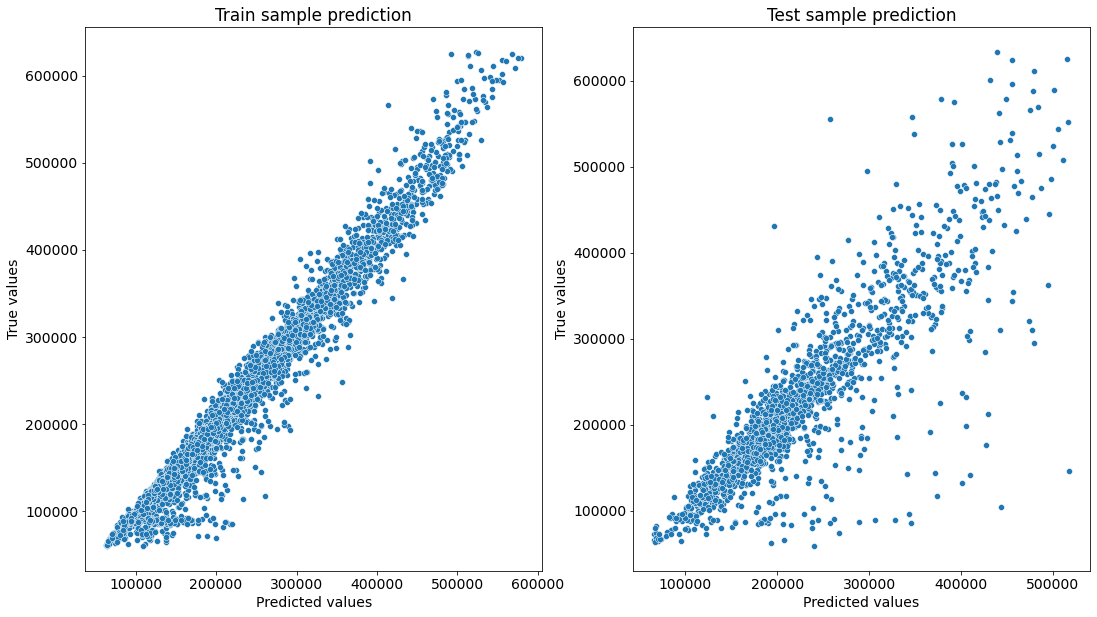

In [85]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [86]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.73696303, 0.7086056 , 0.70082118, 0.75449271, 0.7205297 ])

In [87]:
cv_score.mean()

0.7242824457700141

**Важность признаков**

In [88]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Square,0.354196
21,DistrictSize,0.199339
1,Rooms,0.100992
12,Social_3,0.042366
27,MedPriceBySocial,0.036614
2,LifeSquare,0.035056
6,HouseYear,0.028365
24,MedPriceByFloorYear,0.028075
7,Ecology_1,0.026173
5,HouseFloor,0.021693


### Прогнозирование на тестовом датасете

In [89]:
test_df.shape

(5000, 28)

In [90]:
test_df

,Square,Rooms,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,HouseFloor_issue,HouseYear_issue,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear,MedYearByDistrict,MedPriceBySquareFloor,MedPriceBySocial
0,36.847630,1.0,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,0,0,0,86.0,0,0,186044.241187,2.0,156611.471870,207845.100660
1,42.493907,1.0,29.493907,10.0,7.0,17.0,2017,0.072158,1,1,...,0,0,0,193.0,0,1,179986.169695,2.0,192683.780737,151261.777244
2,59.463678,2.0,47.463678,9.0,19.0,19.0,1977,0.211401,1,1,...,0,0,1,691.0,0,1,174137.278013,2.0,168651.545666,174162.081767
3,49.646030,3.0,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,0,0,0,444.0,0,1,182128.021554,2.0,183490.324647,151261.777244
4,53.837056,1.0,47.837056,3.0,8.0,17.0,1977,0.309479,1,1,...,0,0,1,81.0,0,0,190891.093552,3.0,192683.780737,194645.124009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,43.177521,2.0,30.339945,5.0,5.0,5.0,1962,0.069660,1,1,...,1,0,0,69.0,0,0,186044.241187,2.0,189341.908219,199828.935032
4996,93.698122,3.0,80.698122,10.0,21.0,27.0,2018,0.060753,1,1,...,0,0,0,29.0,0,0,195066.700021,4.0,319471.086202,263610.596640
4997,33.656723,1.0,19.003259,5.0,2.0,5.0,1966,0.038693,1,1,...,0,0,0,70.0,0,0,182128.021554,2.0,159107.038756,196512.596034
4998,38.635155,1.0,20.976257,9.0,8.0,14.0,1970,0.089040,1,1,...,0,0,0,46.0,0,0,190891.093552,2.0,165951.017468,217574.002517


In [91]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [92]:
predictions = rf_model.predict(test_df)
predictions

array([154599.49511442, 126496.60329615, 136279.2443334 , ...,
       146629.33244098, 192525.02408178, 253720.57292904])

In [93]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,154599.495114
1,5925,126496.603296
2,960,136279.244333
3,3848,125705.159814
4,746,207731.677949


In [94]:
submit.to_csv('prediction_sub.csv', index=False)